In [15]:
import os
import re
from collections import defaultdict

import torch
import numpy as np
from transformers import pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    classification_report,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr

from models_mod_cop import Bleurt, Mpnet, ModernBERT, ModelInput

torch.set_float32_matmul_precision("high")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [17]:
pipes = {
    "Mpnet_pipe": Mpnet("lear-lab/short-answer-classification"),
    "Bleurt_pipe": Bleurt(),
    "ModernBERT_pipe": ModernBERT(),
}

Device set to use cpu
Device set to use cpu
Device set to use cpu


In [18]:
df = (
    pd.read_csv("../../data/cri_annotations_with_o3.csv")
    .rename(
        columns={
            "response": "candidate",
            "answer": "reference",
            "chunk_text": "text",
            "score": "human_score",
        }
    )
    .assign(label=lambda x: (x["human_score"] > 2).astype(int))
)
df.sample(5)

,question_id,chunk_header,text,question,reference,candidate,human_score,annotator,labels,id,o3_mini_score,label
85,7f942223-a062-4179-b296-90a23789692e,0.3 Integrating Affect Models in Affect-Aware ...,The interaction- and bodily-based affect detec...,What is the aim of affect-aware learning techn...,The aim is to expand the adaptivity of current...,adaptivity,1.0,Joon,0,7f942223-a062-4179-b296-90a23789692e,2,0
372,20f17f06-3055-452a-ae68-4e689e575577,Conclusion,Information visualization concepts and methodo...,What is the importance of information visualiz...,"They help shape the learning process, encourag...",answer,1.0,Adithya,0,20f17f06-3055-452a-ae68-4e689e575577,1,0
138,2746,A Healthy Climate for Economic Growth,While physical and human capital deepening and...,What are some examples of areas in which gover...,"Education, savings and investment, infrastruct...",Growth accounting studies,2.0,Anna,1,2746,1,0
107,2ee075f1-5675-4b81-9e1b-b42b090e3951,1.4 Teacher Analytics,Teachers should not be left out of the loop si...,What are researchers developing methods for in...,Researchers are developing methods for automat...,They are developing automatic analysis of teac...,4.0,Wes,1,2ee075f1-5675-4b81-9e1b-b42b090e3951,4,1
242,206,Arrow Functions,"There’s a third notation for functions, which ...",What is the purpose of using an arrow function...,Arrow functions were added in 2015 to write sm...,to write small function expressions in a less ...,4.0,Qiushi,1,206,4,1


In [19]:
def score(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(
            y_true, y_pred, average="macro", zero_division=0
        ),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "precision_micro": precision_score(
            y_true, y_pred, average="micro", zero_division=0
        ),
        "recall_micro": recall_score(y_true, y_pred, average="micro", zero_division=0),
        "f1_micro": f1_score(y_true, y_pred, average="micro", zero_division=0),
    }


def print_metrics(model_name, m: dict):
    print(f"{model_name}:")
    print(f"  Accuracy: {m['accuracy']:.4f}")
    print(f"  F1 (macro): {m['f1_macro']:.4f}")
    print(f"  F1 (micro): {m['f1_micro']:.4f}")
    print(f"  Precision (macro): {m['precision_macro']:.4f}")
    print(f"  Recall (macro): {m['recall_macro']:.4f}")
    print()


def evaluate_and_score(dataframe, pipes, label_key="labels"):
    all_preds = defaultdict(list)

    for name, pipe in pipes.items():
        for ex in df.to_dict("records"):
            model_input = ModelInput.from_dict(ex)
            pred = pipe(model_input)
            all_preds[name].append(pred)

    score_gt_2 = [1 if score > 2 else 0 for score in dataframe["human_score"]]
    metrics = {name: score(score_gt_2, all_preds[name]) for name in pipes}
    o3_mini_score_gt_2 = [1 if score > 2 else 0 for score in dataframe["o3_mini_score"]]
    metrics["o3_mini"] = score(score_gt_2, o3_mini_score_gt_2)
    return all_preds, metrics


all_preds, results = evaluate_and_score(df, pipes)

for model_name, m in results.items():
    print_metrics(model_name, m)

Token indices sequence length is longer than the specified maximum sequence length for this model (217 > 128). Running this sequence through the model will result in indexing errors


Mpnet_pipe:
  Accuracy: 0.7367
  F1 (macro): 0.7246
  F1 (micro): 0.7367
  Precision (macro): 0.7388
  Recall (macro): 0.7217

Bleurt_pipe:
  Accuracy: 0.7265
  F1 (macro): 0.7151
  F1 (micro): 0.7265
  Precision (macro): 0.7261
  Recall (macro): 0.7126

ModernBERT_pipe:
  Accuracy: 0.7510
  F1 (macro): 0.7334
  F1 (micro): 0.7510
  Precision (macro): 0.7666
  Recall (macro): 0.7302

o3_mini:
  Accuracy: 0.7367
  F1 (macro): 0.7357
  F1 (micro): 0.7367
  Precision (macro): 0.7700
  Recall (macro): 0.7569



In [20]:
result_df = pd.DataFrame.from_dict(results, orient="index")
result_df.round(4)

,accuracy,precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro
Mpnet_pipe,0.7367,0.7388,0.7217,0.7246,0.7367,0.7367,0.7367
Bleurt_pipe,0.7265,0.7261,0.7126,0.7151,0.7265,0.7265,0.7265
ModernBERT_pipe,0.7510,0.7666,0.7302,0.7334,0.7510,0.7510,0.7510
o3_mini,0.7367,0.7700,0.7569,0.7357,0.7367,0.7367,0.7367


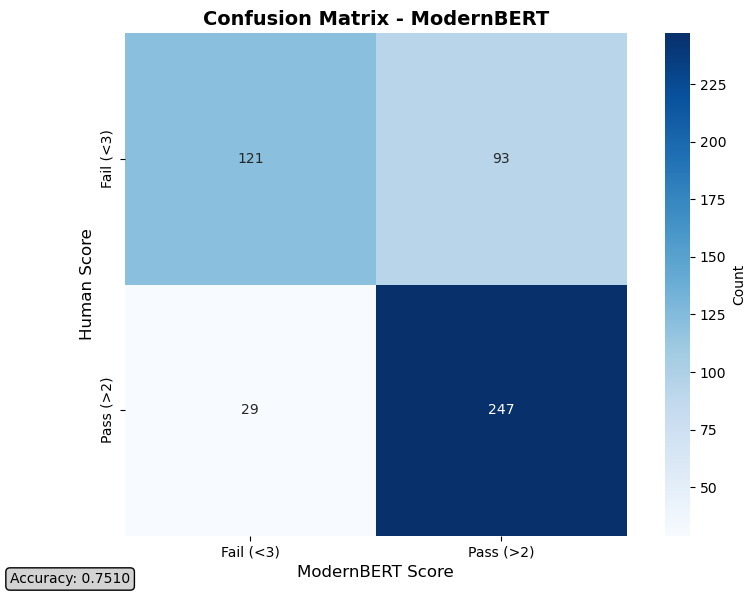

array([[121,  93],
       [ 29, 247]])

In [21]:
def plot_confusion_matrix_heatmap(
    y_true, y_pred, model_name="ModernBERT", figsize=(8, 6)
):
    """
    Create a confusion matrix heatmap using seaborn.

    Parameters:
    y_true: True labels
    y_pred: Predicted labels
    model_name: Name of the model for the title
    figsize: Figure size tuple
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Get unique labels for axis labels
    labels = sorted(list(set(y_true) | set(y_pred)))
    if len(labels) == 2:
        labels = ["Fail (<3)", "Pass (>2)"]

    # Create the plot
    plt.figure(figsize=figsize)

    # Create heatmap
    sns.heatmap(
        cm,
        annot=True,  # Show numbers in cells
        fmt="d",  # Format as integers
        cmap="Blues",  # Color scheme
        xticklabels=labels,  # X-axis labels
        yticklabels=labels,  # Y-axis labels
        cbar_kws={"label": "Count"},
        square=True,
    )  # Make cells square

    plt.title(f"Confusion Matrix - {model_name}", fontsize=14, fontweight="bold")
    plt.xlabel(f"{model_name} Score", fontsize=12)
    plt.ylabel("Human Score", fontsize=12)
    plt.tight_layout()

    # Optional: Add accuracy to the plot
    accuracy = np.trace(cm) / np.sum(cm)
    plt.figtext(
        0.02,
        0.02,
        f"Accuracy: {accuracy:.4f}",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"),
    )

    plt.show()

    return cm


human_score_gt_2 = [1 if score > 2 else 0 for score in df["human_score"]]
plot_confusion_matrix_heatmap(human_score_gt_2, all_preds["ModernBERT_pipe"])

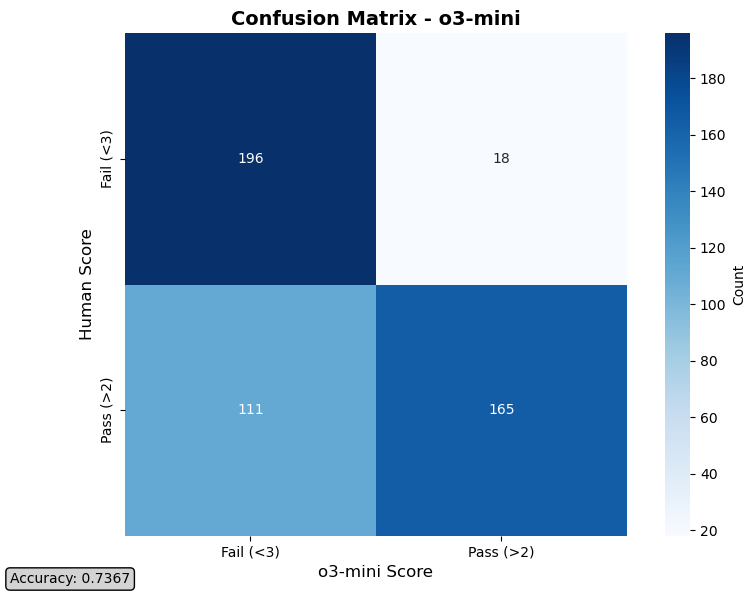

array([[196,  18],
       [111, 165]])

In [22]:
human_score_gt_2 = [1 if score > 2 else 0 for score in df["human_score"]]
o3_mini_score_gt_2 = [1 if score > 2 else 0 for score in df["o3_mini_score"]]
plot_confusion_matrix_heatmap(
    human_score_gt_2, o3_mini_score_gt_2, model_name="o3-mini"
)

o3 mini:
  Accuracy: 0.5469
  F1 (macro): 0.5514
  F1 (micro): 0.5469
  Precision (macro): 0.5709
  Recall (macro): 0.5705



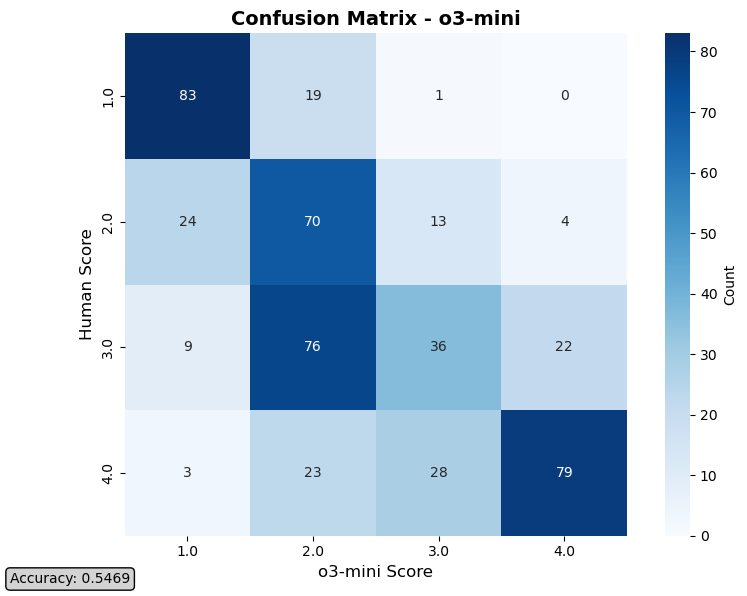

array([[83, 19,  1,  0],
       [24, 70, 13,  4],
       [ 9, 76, 36, 22],
       [ 3, 23, 28, 79]])

In [23]:
m = score(df["human_score"], df["o3_mini_score"])
print_metrics("o3 mini", m)

plot_confusion_matrix_heatmap(
    df["human_score"], df["o3_mini_score"], model_name="o3-mini"
)